In [1]:
# %load sample-wine.py
import pandas as pd
import numpy as np

df_wine = pd.read_csv('../data/wine/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Class labels [1 2 3]


In [2]:
from sklearn.linear_model import LogisticRegression

In [3]:
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [4]:
# 访问截距项
lr.intercept_

array([-1.26402405, -1.21585171, -2.37055207])

In [5]:
# 权重陈列
# 每行为一组权重向量，每行有13个权重
lr.coef_

array([[ 1.24651047,  0.18039823,  0.74681408, -1.16431276,  0.        ,
         0.        ,  1.15741602,  0.        ,  0.        ,  0.        ,
         0.        ,  0.56063294,  2.50829845],
       [-1.53734272, -0.38743408, -0.99544954,  0.36512228, -0.05950207,
         0.        ,  0.66830277,  0.        ,  0.        , -1.93440574,
         1.23334752,  0.        , -2.23157237],
       [ 0.13573266,  0.1682809 ,  0.35712952,  0.        ,  0.        ,
         0.        , -2.43849123,  0.        ,  0.        ,  1.56369566,
        -0.81924614, -0.49193719,  0.        ]])

改变正则化强度并测算正则化路径，即不同特征在不同正则化强度下的权重系数

[L1与L2正则化](https://cloud.tencent.com/developer/article/1708679)

In [6]:
weights, params = [], []

for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0, solver='liblinear')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

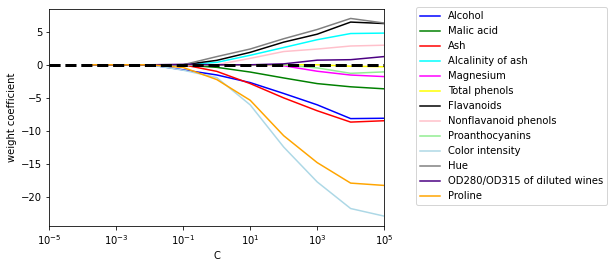

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column + 1], color=color)

plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)

plt.show()

为序数特征选择算法

In [12]:
# %load SBS.py
# 特征选择算法
# 叙述特征选择算法：逆顺序选择（SBS）
# 目的是应对分类器性能最小的衰减来降低初始特征子空间的维数，从而提高计算效率
# 算法逻辑：
# 1. 用 k=d 初始化算法，d 为特征空间 X_d 的维数
# 2. 确定使标准值最大的特征 x^-，即 x^- = argmax J(X_k - x)，其中x \in X_k
# 3. 从特征集中去除特征x^-：X_{k-1} = X_k - x^-, k=k-1
# 4. 如果 k 等于期望的特征数则停止，否则转往步骤2

from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        
        self.k_score_ = self.scores_[-1]

        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

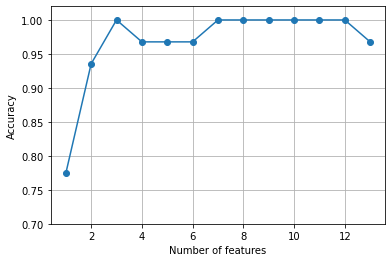

In [14]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [16]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [17]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629
